In [1]:
import math
import json
from functools import reduce

import numpy as np
import torch
import torchaudio
import torchaudio.functional as AF

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import librosa
import librosa.display

import mido
from mido import MidiFile

from utils.datasets import ChoralSingingDataset
from utils.transforms import BoxCoxTransform, ZScoreTransform, PowerToDecibelTransform, ScaleToIntervalTransform

import scipy

E:\MiniConda3\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
def freq2note(freq, concert_a=440):
    return int(12 * math.log2(freq / concert_a) + 69)

def note2freq(note, concert_a=440):
    return 2 ** ((note - 69) / 12.0) * 440.0

def note2name(note):
    lookup = ['A', 'A#/Bb', 'B', 'C', 'C#/Db', 'D', 'D#/Eb', 'E', 'F', 'F#/Gb', 'G', 'G#/Ab']
    name = (note + 3) % 12
    octave = (note // 12) - 1
    return f'{lookup[name]}{octave}'

def tick2time(tick, ticks_per_beat, tempo):
    return (float(tick) / ticks_per_beat) * tempo * 1e-6

def time2tick(time, ticks_per_beat, tempo):
    return int(((time / 1e-6) / tempo) * ticks_per_beat)

def frame2time(frame, sr):
    return float(frame) / sr

def time2frame(time, sr):
    return int(time * sr)

In [3]:
"""
Original Lyrics:

    El Rossinyol (ER, Catalan):

        Rossinyol que vas a França, rossinyol,
        encomana'm a la mare, rossinyol,
        d'un bell bocatge rossinyol, d'un vol.

        Encomana'm a la mare, rossinyol,
        i a mon pare no pas gaire, rossinyol,
        d'un bell bocatge, rossinyol, d'un vol.

        A mon pare no pas gaire, rossinyol,
        perquè a un pastor me n’ha dada, rossinyol,
        d'un bell bocatge, rossinyol, d'un vol.

        Perquè a un pastor me n’ha dada, rossinyol,
        que em fa guardar la ramada, rossinyol,
        d'un bell bocatge, rossinyol, d'un vol.

    Locus Iste (LI, Latin):

        Locus iste a Deo factus est,
        inaestimabile sacramentum,
        irreprehensibilis est.

IPA Syllabified Phonemic Lyrics:

    El Rossinyol (ER):

        ro si ɲɔl kə bas a fran sə ro si ɲɔl
        əŋ ku mə nam a la ma rə ro si ɲɔl
        dun beʎ bu ka dʒə ro si ɲɔl du:n bol

    Locus Iste (LI):

        lo kus is te a de o fak tus est
        i nes ti ma bi le sa kra men tum
        ir re pre en si bi lis est

"""

"\nOriginal Lyrics:\n\n    El Rossinyol (ER, Catalan):\n\n        Rossinyol que vas a França, rossinyol,\n        encomana'm a la mare, rossinyol,\n        d'un bell bocatge rossinyol, d'un vol.\n\n        Encomana'm a la mare, rossinyol,\n        i a mon pare no pas gaire, rossinyol,\n        d'un bell bocatge, rossinyol, d'un vol.\n\n        A mon pare no pas gaire, rossinyol,\n        perquè a un pastor me n’ha dada, rossinyol,\n        d'un bell bocatge, rossinyol, d'un vol.\n\n        Perquè a un pastor me n’ha dada, rossinyol,\n        que em fa guardar la ramada, rossinyol,\n        d'un bell bocatge, rossinyol, d'un vol.\n\n    Locus Iste (LI, Latin):\n\n        Locus iste a Deo factus est,\n        inaestimabile sacramentum,\n        irreprehensibilis est.\n\nIPA Syllabified Phonemic Lyrics:\n\n    El Rossinyol (ER):\n\n        ro si ɲɔl kə bas a fran sə ro si ɲɔl\n        əŋ ku mə nam a la ma rə ro si ɲɔl\n        dun beʎ bu ka dʒə ro si ɲɔl du:n bol\n\n    Locus Iste (LI):\n

In [4]:
def process_midi(path):
    midi = MidiFile(path)
    ticks_per_beat = midi.ticks_per_beat
    tempo = 0
    cum_ticks = 0
    cum_time = 0.0
    notes = []
    note_dict = {}
    notes_set = set()

    for msg in midi.tracks[0]:
        if msg.type == "set_tempo":
            tempo = msg.tempo

        elif msg.type == "note_on" or msg.type == "note_off":
            time_since_last_event = ((float(msg.time) / ticks_per_beat) * tempo) * 1e-6
            cum_time += time_since_last_event
            cum_ticks += msg.time
            if msg.type == "note_on":
                # Push it to the stack
                notes_set.add(msg.note)
                note_dict[msg.note] = (msg.note, cum_ticks)
            else:
                current_note = note_dict[msg.note]
                notes.append((*current_note, cum_ticks - current_note[1]))
    return ticks_per_beat, tempo, cum_ticks, cum_time, notes, notes_set

def plot_midi(path, ax, **kwargs):
    ticks_per_beat, tempo, cum_ticks, cum_time, notes, notes_set = process_midi(path)
    tick2time = lambda tick: (float(tick) / ticks_per_beat) * tempo * 1e-6
    ys = [(note, 1) for note in notes_set if note is not None]
    for y in ys:
        xs = [(tick2time(note[1]), tick2time(note[2])) for note in notes if note[0] == y[0]]
        y_base = note2freq(y[0] - 0.5)
        y_height = note2freq(y[0] + 0.5) - y_base
        true_y = (y_base, y_height)
        ax.broken_barh(xs, true_y, **kwargs)

In [5]:
dataset_path = 'data/ChoralSingingDataset'
time_idx = 'Time (s)'
f0_dfs = {}
for excerpt in ('ER', 'LI', 'ND'):
    dataframes = []
    part_idxes = {}
    for part in ('soprano', 'alto', 'tenor', 'bass'):
        part_idxes[part] = []
        for singer in range(1, 5):
            part_idx = f'{part.title()} {singer} (Hz)'
            df = pd.read_csv(f'{dataset_path}/CSD_{excerpt}_{part}_{singer}.f0', sep=' ', names=[time_idx, part_idx], index_col=0)
            df.loc[df[part_idx] == 0.0, part_idx] = None
            dataframes.append(df)
            part_idxes[part].append(part_idx)
    f0_df = reduce(lambda a, b: a.merge(b, on=time_idx), dataframes)
    for part_name, part_idxs in part_idxes.items():
        f0_df[f'{part_name.title()} Average (Hz)'] = f0_df[part_idxs].mean(axis=1)
    f0_dfs[excerpt] = f0_df

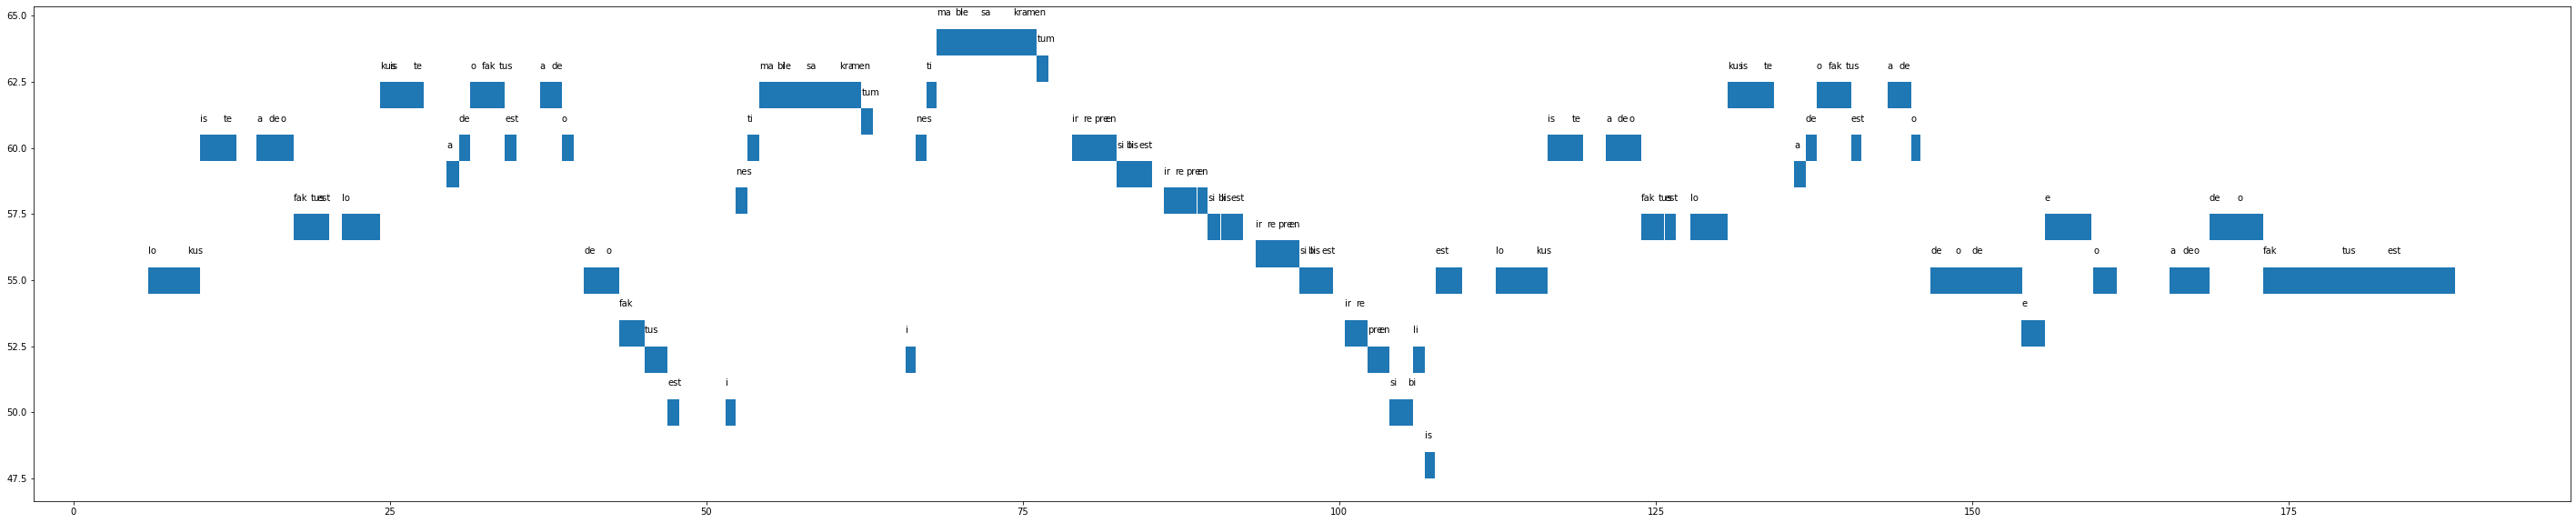

In [6]:
def add_lyrics_to_notes(notes, path, part, silence='<SIL>'):
    new_notes = []
    with open(path) as fp:
        lyrics = json.load(fp)[part]
        for note in notes:
            if note[0] is None:
                new_notes.append((*note, silence))
            else:
                try:
                    lyric = lyrics.pop(0)
                except IndexError:
                    raise IndexError("Not enough lyrics")
                new_notes.append((*note, lyric))
        assert len(lyrics) == 0, "Left over lyrics"
    return new_notes

fig, ax = plt.subplots(figsize=(50,10))
ticks_per_beat, tempo, cum_ticks, cum_time, notes, notes_set = process_midi(f'{dataset_path}/CSD_LI_tenor_midi.mid')
notes = add_lyrics_to_notes(notes, f'{dataset_path}/CSD_LI_lyrics.json', 'tenor')
ys = [(note, 1) for note in notes_set if note is not None]
for y in ys:
    xs = [(tick2time(note[1], ticks_per_beat, tempo), tick2time(note[2], ticks_per_beat, tempo)) for note in notes if note[0] == y[0]]
    y_base = y[0] - 0.5
    y_height = y[0] + 0.5 - y_base
    true_y = (y_base, y_height)
    ax.broken_barh(xs, true_y)
    for note in notes:
        if note[0] == y[0]:
            ax.text(tick2time(note[1], ticks_per_beat, tempo), y[0] + 1, note[3]) if note[3] != "<SIL>" else None

In [7]:
for note in notes:
    print(note)

(55, 5702, 2967, 'lo')
(55, 8669, 960, 'kus')
(60, 9634, 1780, 'is')
(60, 11414, 936, 'te')
(60, 13877, 897, 'a')
(60, 14779, 946, 'de')
(60, 15725, 960, 'o')
(57, 16690, 1334, 'fak')
(57, 18024, 432, 'tus')
(57, 18461, 931, 'est')
(57, 20386, 2875, 'lo')
(62, 23261, 768, 'kus')
(62, 24034, 1756, 'is')
(62, 25790, 812, 'te')
(59, 28291, 946, 'a')
(60, 29237, 869, 'de')
(62, 30106, 854, 'o')
(62, 30965, 1325, 'fak')
(62, 32294, 428, 'tus')
(60, 32726, 845, 'est')
(62, 35362, 859, 'a')
(62, 36226, 820, 'de')
(60, 37046, 903, 'o')
(55, 38707, 1709, 'de')
(55, 40421, 974, 'o')
(53, 41395, 1944, 'fak')
(52, 43339, 1738, 'tus')
(50, 45082, 840, 'est')
(50, 49478, 759, 'i')
(58, 50237, 888, 'nes')
(60, 51130, 878, 'ti')
(62, 52013, 1349, 'ma')
(62, 53366, 428, 'bi')
(62, 53794, 1728, 'le')
(62, 55526, 2554, 'sa')
(62, 58080, 826, 'kra')
(62, 58910, 850, 'men')
(61, 59765, 864, 'tum')
(52, 63082, 820, 'i')
(60, 63902, 797, 'nes')
(62, 64699, 783, 'ti')
(64, 65486, 1344, 'ma')
(64, 66835, 403, 

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(50,30))
for i, song in enumerate(['ER', 'LI', 'ND']):
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Soprano 1 (Hz)'], alpha=0.25, color='tab:blue')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Soprano 2 (Hz)'], alpha=0.25, color='tab:blue')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Soprano 3 (Hz)'], alpha=0.25, color='tab:blue')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Soprano 4 (Hz)'], alpha=0.25, color='tab:blue')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Soprano Average (Hz)'], alpha=1, color='tab:blue', label='Soprano Average (Hz)')

    if song == "LI":
        for part in ["soprano", "alto", "tenor", "bass"]:
            ticks_per_beat, tempo, cum_ticks, cum_time, notes, notes_set = process_midi(f'{dataset_path}/CSD_LI_{part}_midi.mid')
            notes = add_lyrics_to_notes(notes, f'{dataset_path}/CSD_LI_lyrics.json', part)
            for note in notes:
                ax[i].text(tick2time(note[1]), note2freq(note[0]), note[3]) if note[3] != "<SIL>" else None

    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Alto 1 (Hz)'], alpha=0.25, color='tab:orange')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Alto 2 (Hz)'], alpha=0.25, color='tab:orange')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Alto 3 (Hz)'], alpha=0.25, color='tab:orange')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Alto 4 (Hz)'], alpha=0.25, color='tab:orange')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Alto Average (Hz)'], alpha=1, color='tab:orange', label='Alto Average (Hz)')

    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Tenor 1 (Hz)'], alpha=0.25, color='tab:green')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Tenor 2 (Hz)'], alpha=0.25, color='tab:green')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Tenor 3 (Hz)'], alpha=0.25, color='tab:green')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Tenor 4 (Hz)'], alpha=0.25, color='tab:green')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Tenor Average (Hz)'], alpha=1, color='tab:green', label='Tenor Average (Hz)')

    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Bass 1 (Hz)'], alpha=0.25, color='tab:red')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Bass 2 (Hz)'], alpha=0.25, color='tab:red')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Bass 3 (Hz)'], alpha=0.25, color='tab:red')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Bass 4 (Hz)'], alpha=0.25, color='tab:red')
    ax[i].plot(f0_dfs[song].index, f0_dfs[song]['Bass Average (Hz)'], alpha=1, color='tab:red', label='Bass Average (Hz)')

    plot_midi(f'{dataset_path}/CSD_{song}_soprano_midi.mid', ax[i], color='tab:blue', alpha=0.25)
    plot_midi(f'{dataset_path}/CSD_{song}_alto_midi.mid', ax[i], color='tab:orange', alpha=0.25)
    plot_midi(f'{dataset_path}/CSD_{song}_tenor_midi.mid', ax[i], color='tab:green', alpha=0.25)
    plot_midi(f'{dataset_path}/CSD_{song}_bass_midi.mid', ax[i], color='tab:red', alpha=0.25)

    ax[i].legend()
    ax[i].set_yscale('log')
    songs = ['El Rossinyol', 'Locus Iste', 'Niño Dios d\'Amor Herido']
    ax[i].set_title(f"{songs[i]} (SATB Fundamental Frequencies)")
    ax[i].set_yticks([note2freq(n) for n in range(36, 85)], minor=True)
    ax[i].set_yticks([note2freq(n) for n in [45, 57, 69, 81]], minor=False)
    ax[i].set_yticklabels(list(map(note2name, range(36, 85))), minor=True)
    ax[i].set_yticklabels(list(map(note2name, [45, 57, 69, 81])))
    ax[i].tick_params(axis='y', which='minor', grid_alpha=0.25)
    ax[i].grid(True, which='both', axis='y')
    ax[i].set_xlim((0, f0_dfs[song].index[-1]))
plt.show()

TypeError: tick2time() missing 2 required positional arguments: 'ticks_per_beat' and 'tempo'

In [9]:
wave, sample_rate = torchaudio.load(f'{dataset_path}/CSD_LI_soprano_1.wav')
resample = torchaudio.transforms.Resample(sample_rate, 16000)
wave = resample(wave)

ticks_per_beat, tempo, cum_ticks, cum_time, notes, notes_set = process_midi(f'{dataset_path}/CSD_LI_soprano_midi.mid')
notes = add_lyrics_to_notes(notes, f'{dataset_path}/CSD_LI_lyrics.json', 'soprano')

n_fft = 400
n_mels = 64

def waveframe2specframe(x):
    return (x // (n_fft // 2)) + 1

print(time2frame(frame2time(wave.shape[1], 16000), 16000//200))
print(wavetime2spectime(wave.shape[1]))

notes = [(*note, time2frame(tick2time(note[1], ticks_per_beat, tempo), 16000 // 200), time2frame(tick2time(note[2], ticks_per_beat, tempo), 16000 // 200)) for note in notes]

melspec = torchaudio.transforms.MelSpectrogram(n_mels=n_mels, n_fft=n_fft, pad_mode="constant") # Start padding is 200
melscale = torchaudio.transforms.MelScale(n_mels=n_mels, sample_rate=sample_rate, n_stft=n_fft)
p2db = PowerToDecibelTransform(ref=torch.max, top_db=80.0)
resize = ScaleToIntervalTransform()

chain = torch.nn.Sequential(melspec, p2db, resize)

wave_spectrogram = chain(wave)

print(wave_spectrogram.shape)

print(notes)

15357


NameError: name 'wavetime2spectime' is not defined

In [ ]:

ig, ax = plt.subplots(figsize=(50,10))
ax.imshow(wave_spectrogram[0], aspect='auto', origin='lower', cmap='magma')
plt.show()

In [31]:
np.save("test", wave_spectrogram[:,:,0:800].numpy())

In [13]:
print(math.ceil(resample(wave).shape[-1] / 312))

6960


In [57]:
list(range(10))[-4::]

[6, 7, 8, 9]

In [12]:
melspec = torchaudio.transforms.MelSpectrogram(n_mels=64, n_fft=400)
melspec_noncentered = torchaudio.transforms.MelSpectrogram(n_mels=64, n_fft=400, center=False)
test = torch.randn((1, 400))

print(melspec(test)[:,:,1])
print(melspec_noncentered(test))

tensor([[  77.2340,   94.2271,  134.9215,  101.3259,   34.2238,   30.6464,
           42.2337,   41.1792,   41.5880,   89.2864,   46.0815,  127.5353,
          439.3853,  543.8556,  182.7853,  137.8807,  405.0763,  259.1032,
           60.1887,    9.7560,   70.5402,  220.9055,  154.3973,  107.3069,
          595.6669,  457.3744,  388.7225,  188.9802,   40.8423,  258.8881,
          245.7386,  293.9000,  127.2967,  694.8655,  389.4047,  216.0827,
          149.2158,  838.9609,  584.8179,  517.1375,  740.6041,  308.8323,
          326.4888,  224.4924,  159.3970, 1079.6984,  817.5202,  243.5157,
          482.3590,  792.8027,  752.1753,  957.8107,  806.0026,  787.8508,
          762.6541, 1043.7021, 1128.2643, 1560.4862, 1695.9774,  782.2429,
          871.5182,  887.1943,  760.5751, 1280.8066]])
tensor([[[  77.2340],
         [  94.2271],
         [ 134.9215],
         [ 101.3259],
         [  34.2238],
         [  30.6464],
         [  42.2337],
         [  41.1792],
         [  41.5880

In [2]:
csd = ChoralSingingDataset('data', 4093)
print(csd.cumulative_lengths)

[15358, 30716, 46074, 61432, 77019, 92606, 108193, 123780, 139268, 154756, 170244, 185732, 200999, 216266, 231533, 246800, 257657, 268514, 279371, 290228, 301058, 311888, 322718, 333548, 344505, 355462, 366419, 377376, 388271, 399169, 410069, 420969, 429284, 437599, 445914, 454229, 462626, 471028, 479430, 487832, 496138, 504448, 512755, 521064, 529418, 537772, 546128, 554483]


torch.Size([1, 4492]) torch.Size([1, 400]) torch.Size([64, 4493])


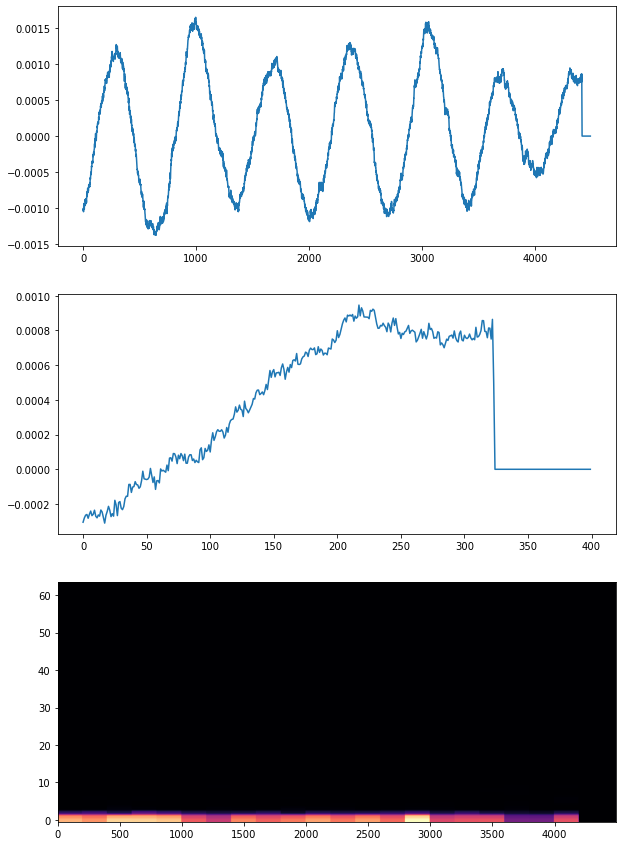

In [4]:
test = csd[15357]
fig, ax = plt.subplots(nrows=3, figsize=(10,15))
ax[0].plot(test[0].squeeze())
ax[1].plot(test[1].squeeze())
ax[2].imshow(np.log(test[2].numpy() + 0.001), aspect='auto', origin='lower', cmap='magma')
plt.show()

In [51]:
def box_cox_transform(x, a, b=0):
    if a == 0:
        return torch.log(x + b)
    else:
        return ((x + b) ** a - 1) / a

In [10]:
test, test_sr = torchaudio.load("data\\VocalSet1-2\\data_by_singer\\female1\\excerpts\\straight\\f1_caro_straight.wav")
test = torchaudio.functional.gain(test, 10)

print(test.max(), test.min())

resample = torchaudio.transforms.Resample(test_sr, 16000)
melspec = torchaudio.transforms.MelSpectrogram(n_mels=64, n_fft=400, pad_mode="constant")
spectrogram = torchaudio.transforms.Spectrogram(n_fft=400, pad_mode="constant")
boxcox = BoxCoxTransform(0.05)
zscore = ZScoreTransform()
p2db = PowerToDecibelTransform(ref=torch.max, top_db=80.0)
resize = ScaleToIntervalTransform()

chainspec = torch.nn.Sequential(resample, spectrogram, p2db)
chain1 = torch.nn.Sequential(resample, melspec, boxcox, zscore)
chain2 = torch.nn.Sequential(resample, melspec, p2db, resize)


spec1 = chain1(test)
test_spec1 = spec1.squeeze()[:,40:640]

spec2 = chain2(test)
# spec2 = torch.from_numpy(librosa.util.normalize(spec2.numpy(), threshold=0.5))
test_spec2 = spec2.squeeze()[:,40:640]

spec3 = librosa.feature.melspectrogram(y=resample(test).squeeze().numpy(), sr=16000, n_fft=400, hop_length=200, n_mels=64, pad_mode="constant", window=scipy.signal.windows.hann, center=True)
spec3 = librosa.core.power_to_db(spec3, ref=np.max, top_db=80.0)
spec3 = torch.from_numpy(spec3)
spec3 = spec3 / 80.0 + 1
test_spec3 = spec3[:,40:640]

# test_wave = test.squeeze()[(40 * 200)-100:(640 * 200)+100]

print(spec1.max(), spec1.min(), spec1.mean(), spec1.std())
print(spec2.max(), spec2.min(), spec2.mean(), spec2.std())
print(spec3.max(), spec3.min(), spec3.mean(), spec3.std())

torch.save(test_spec2, "test_spec2.pt")

tensor(0.8198) tensor(-0.6553)
tensor(3.8562) tensor(-2.5885) tensor(7.6206e-08) tensor(1.)
tensor(1.) tensor(0.) tensor(0.2939) tensor(0.2217)
tensor(1.) tensor(0.) tensor(0.2642) tensor(0.2225)


E:\MiniConda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
E:\MiniConda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
E:\MiniConda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


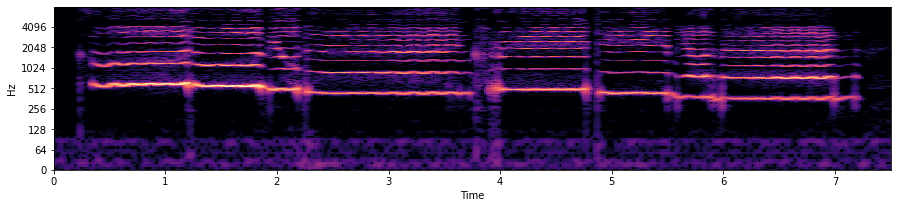

In [11]:
fig, ax = plt.subplots(figsize=(15,3))
D = librosa.amplitude_to_db(np.abs(librosa.stft(resample(test).squeeze().numpy(), hop_length=200)), ref=np.max)
librosa.display.specshow(D[:,40:640], y_axis='log', sr=16000, hop_length=200, x_axis='time', ax=ax)
plt.show()

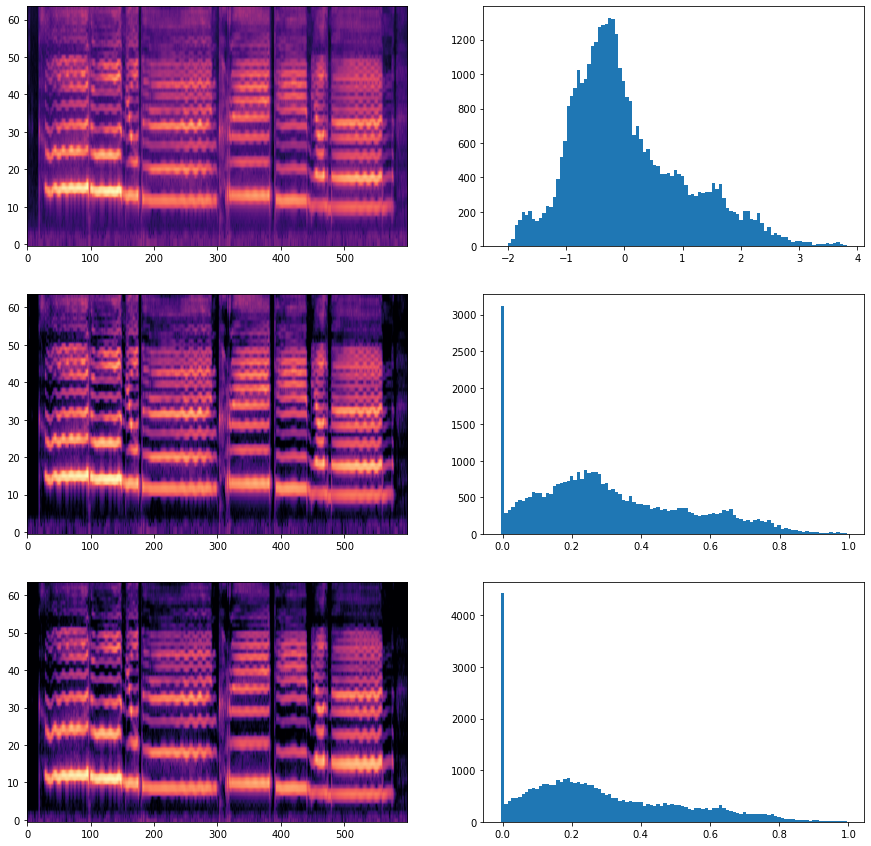

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(15,15))
ax[0][0].imshow(test_spec1.squeeze(), aspect='auto', origin='lower', cmap='magma')
ax[0][1].bar(np.linspace(test_spec1.min().item(), test_spec1.max().item(), 100, endpoint=False), torch.histc(test_spec1), width=((test_spec1.min().item() - test_spec1.max().item()) / 100))

ax[1][0].imshow(test_spec2.squeeze(), aspect='auto', origin='lower', cmap='magma')
ax[1][1].bar(np.linspace(test_spec2.min().item(), test_spec2.max().item(), 100, endpoint=False), torch.histc(test_spec2), width=((test_spec2.min().item() - test_spec2.max().item()) / 100))

ax[2][0].imshow(test_spec3, aspect='auto', origin='lower', cmap='magma')
ax[2][1].bar(np.linspace(test_spec3.min().item(), test_spec3.max().item(), 100, endpoint=False), torch.histc(test_spec3), width=((test_spec3.min().item() - test_spec3.max().item()) / 100))
plt.show()

tensor(0.7943) tensor(-0.6112)
tensor(1.) tensor(0.) tensor(0.2147) tensor(0.2065)


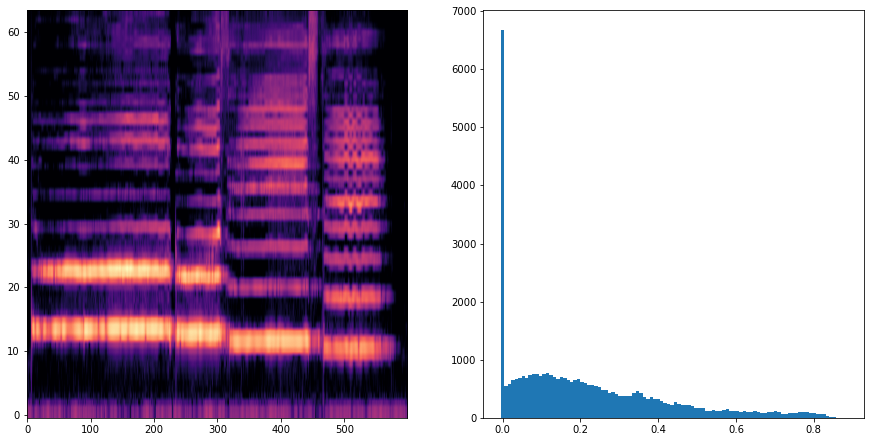

In [13]:
test, test_sr = torchaudio.load("data\\ChoralSingingDataset\\CSD_LI_soprano_1.wav")
print(test.max(), test.min())
spec = chain2(test)
test_spec = spec.squeeze()[:,480:1080]
print(spec.max(), spec.min(), spec.mean(), spec.std())

fig, ax = plt.subplots(ncols=2, figsize=(15,7.5))
ax[0].imshow(test_spec, aspect='auto', origin='lower', cmap='magma')
ax[1].bar(np.linspace(test_spec.min().item(), test_spec.max().item(), 100, endpoint=False), torch.histc(test_spec), width=((test_spec.min().item() - test_spec.max().item()) / 100))
plt.show()

In [14]:
a = {"a", "e", "i", "o", "u"}
b = zip(list(a), range(len(a)))
print(dict(b))

{'a': 0, 'u': 1, 'e': 2, 'o': 3, 'i': 4}


In [15]:
a = torch.zeros((10,))
a[5] = 1
a.nonzero().item()

5

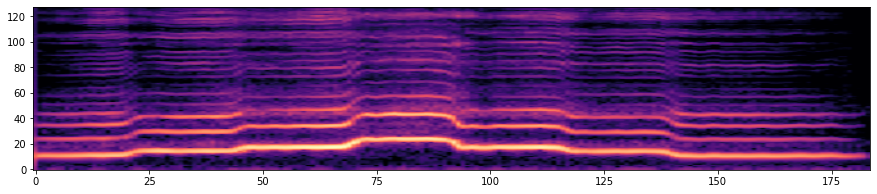

In [13]:
test, test_sr = torchaudio.load("data\\VocalSet\\data_by_singer\\female9\\arpeggios\\breathy\\f9_arpeggios_breathy_u.wav")
fig, ax = plt.subplots(figsize=(15,3))
test = torchaudio.transforms.Resample(44100, 16000)(test)
test = torchaudio.transforms.Vad(16000, trigger_level=1.0)(test).flip(dims=(-1,))
test = torchaudio.transforms.Vad(16000, trigger_level=1.0)(test).flip(dims=(-1,))
test = torchaudio.transforms.MelSpectrogram(n_fft=800, n_mels=128, pad_mode='constant', f_min=80.0, f_max=8000.0)(test)
test = torch.log(torch.clamp(test, min=1e-5))
ax.imshow(test.squeeze(), aspect='auto', origin='lower', cmap='magma')
plt.show()